<a href="https://colab.research.google.com/github/Sudeepthi13/PDS/blob/main/Topicmodeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install gensim pyarrow pandas
%pip install nltk
%pip install seaborn
%pip install scikit-learn
%pip install matplotlib

from gensim.models import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import pandas as pd
import nltk # type: ignore
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/nyt_data.parquet'  # Update path if using Google Drive
data = pd.read_parquet(file_path)
# Inspect the dataset
print(data.head())
print(data.info())

# Confirm which column contains the article text
print(data.columns)

   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   

                                             excerpt  
0                                                     
1  Service Board to Further Examine I.R.T. Safety...  
2                                                     
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Suspiciou...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17370913 entries, 0 to 17370912
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   year     int64 
 1   title    object
 2   excerpt  object
dtypes: int64(1), object(2)
memory usage: 397.6+ MB
None
Index(['year', 'title

In [ ]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Enhanced preprocessing function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    # Define stopwords (extend the default list with custom ones)
    stop_words = set(stopwords.words('english')).union({"pm", "mr", "st", "th", "friday", "saturday", "monday", "dec", "year", "new"})

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters and spaces
    text = re.sub(r'\s+', ' ', text)  # Normalize whitespace

    # Tokenize, lemmatize, and remove stopwords
    tokens = [
        lemmatizer.lemmatize(word.lower())
        for word in text.split()
        if word.lower() not in stop_words and len(word) > 2  # Remove short words
    ]
    return tokens


In [ ]:
# Apply preprocessing to a sample of 5000 articles (adjust size as needed)
data_sample = data.sample(n=5000, random_state=42)
data_sample['processed_text'] = data_sample['excerpt'].apply(preprocess_text)

# Display the first 10 rows
print(data.head(10))


   year                                              title  \
0  1920  At last the Federal Reserve Board has issued r...   
1  1920                            WILL TEST DOOR SERVICE.   
2  1920                    Sanction for Chinese Contracts.   
3  1920                            LEADS FRAZIER BY 4,496.   
4  1920  CHICAGO, April 30.--With 300 suspicious charac...   
5  1920                                    CURRENT HISTORY   
6  1920  Copyright, 1920, by The New York Times Company...   
7  1920  The fact that the moving picture magnates are ...   
8  1920  WASHINGTON, May 1.--Five and ten cent daily ne...   
9  1920                                 COMMERCIAL LEASES.   

                                             excerpt  
0                                                     
1  Service Board to Further Examine I.R.T. Safety...  
2                                                     
3  Langer's Margin Falls in North Dakota--Gronna ...  
4  Federal Agents and Police Round-- up Su

In [ ]:
# Create Dictionary and Corpus
texts = data_sample['processed_text'].tolist()
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


#NMF



In [ ]:
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data_sample['processed_text_str'] = data_sample['processed_text'].apply(lambda x: ' '.join(x))
print(data_sample[['processed_text', 'processed_text_str']].head())

                                             processed_text  \
871974    [sail, rye, june, plan, personnel, putnam, nus...   
3563372   [straus, say, project, held, investigation, te...   
11774055                                                 []   
11142793  [rally, presided, gen, eurico, jesus, deus, co...   
10942590  [lost, record, major, tired, following, septem...   

                                         processed_text_str  
871974    sail rye june plan personnel putnam nusbaum bo...  
3563372   straus say project held investigation tenanted...  
11774055                                                     
11142793  rally presided gen eurico jesus deus corvacho ...  
10942590  lost record major tired following september sh...  


In [ ]:
# TF-IDF Vectorization for NMF and LSA
vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm_sample = vectorizer.fit_transform(data_sample['processed_text_str'])

In [ ]:
#Apply NMF
nmf_model_sample = NMF(n_components=12, random_state=42, max_iter=500)
nmf_topics_sample = nmf_model_sample.fit_transform(dtm_sample)




In [ ]:
import numpy as np
import pandas as pd

# Calculate the sum of topics for each document
row_sums = nmf_topics_sample.sum(axis=1, keepdims=True)

# Replace zero sums with 1 to avoid division by zero
row_sums[row_sums == 0] = 1

# Normalize the nmf_topics_sample matrix to get percentage contributions
document_topic_percentage = nmf_topics_sample / row_sums

# Convert to percentages
document_topic_percentage = document_topic_percentage * 100

# Create a DataFrame for better readability
doc_topic_df = pd.DataFrame(
    document_topic_percentage,
    columns=[f"Topic {i + 1}" for i in range(document_topic_percentage.shape[1])]
)

# Add a column for document index
doc_topic_df.index.name = 'Document'

# Display the first few rows
print(doc_topic_df.head())



           Topic 1    Topic 2   Topic 3    Topic 4    Topic 5    Topic 6  \
Document                                                                   
0         0.113391   7.071356  4.329611   0.000000   0.055888   4.479279   
1         0.000000  98.081835  1.227423   0.000000   0.000000   0.000000   
2         0.000000   0.000000  0.000000   0.000000   0.000000   0.000000   
3         1.959839   5.253995  2.607633  42.499858   4.547566   0.000000   
4         0.830125   0.000000  5.551379   0.920133  28.790043  22.532093   

           Topic 7   Topic 8    Topic 9   Topic 10   Topic 11   Topic 12  
Document                                                                  
0         2.622932  3.014242  66.985695   0.000000   4.394595   6.933010  
1         0.000000  0.690742   0.000000   0.000000   0.000000   0.000000  
2         0.000000  0.000000   0.000000   0.000000   0.000000   0.000000  
3         4.920902  1.057868  12.728422   4.548699  10.002905   9.872313  
4         0.00000

In [ ]:
# Function to display top words
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Now you can access the feature names
print("\nNMF Topics (Sample Data):")
print_top_words(nmf_model_sample, vectorizer.get_feature_names_out())


NMF Topics (Sample Data):
Topic #1:
photo great world title music fall school street bush hope come cause dead finish production space director early place good
Topic #2:
say cost figure party talk official held police result charge year bush control offer german leader work governor john life
Topic #3:
home win mr miss today bride defeat victor beat play score club set open church event final married lead class
Topic #4:
illus idea people west general early force world use country described design case teacher report noted face police met note
Topic #5:
game star victory team opening league season player final set beat defeat lead big point tonight rival white play score
Topic #6:
york company make philadelphia world paul hard american friend old william great half dy national head married man discussed central
Topic #7:
city work jersey church married case mayor seek jury store paper official second boy hall share better owner measure strike
Topic #8:
president vice college named po

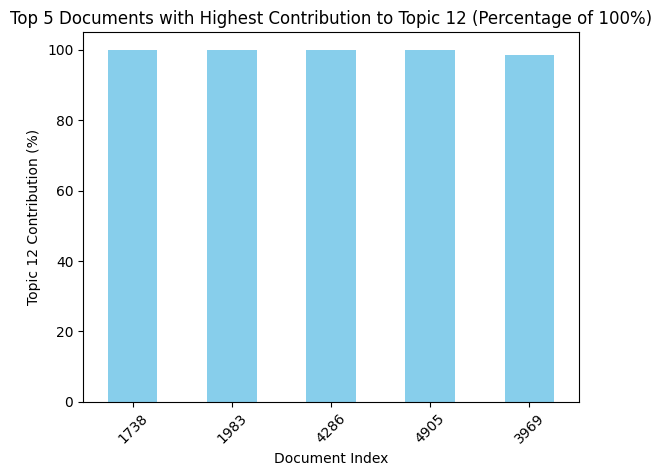

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

topic_contribution_per_doc = pd.DataFrame(nmf_topics_sample, columns=[f"Topic {i+1}" for i in range(nmf_topics_sample.shape[1])])

row_sums = topic_contribution_per_doc.sum(axis=1).values.reshape(-1, 1)
topic_contribution_percentage = topic_contribution_per_doc / row_sums * 100
topic_12_docs_contrib_percentage = topic_contribution_percentage["Topic 12"]

top_5_topic_12_docs_contrib_percentage = topic_12_docs_contrib_percentage.nlargest(5)

top_5_topic_12_docs_contrib_percentage.plot(kind='bar', color='skyblue')
plt.title("Top 5 Documents with Highest Contribution to Topic 12 (Percentage of 100%)")
plt.xlabel("Document Index")
plt.ylabel("Topic 12 Contribution (%)")
plt.xticks(rotation=45)
plt.show()

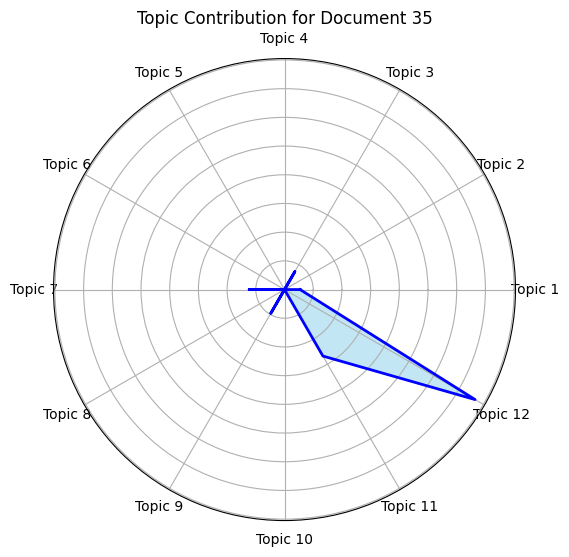

In [ ]:
import numpy as np

document_idx = 34  # Change this index to select different documents
document_contrib = topic_contribution_per_doc.iloc[document_idx, :]

# Create radar chart
labels = [f"Topic {i+1}" for i in range(len(document_contrib))]
values = document_contrib.values
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# Make the radar chart close to a circle
values = np.concatenate((values, [values[0]]))
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.5)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title(f"Topic Contribution for Document {document_idx + 1}")
plt.show()

In [ ]:
# Coherence for NMF
nmf_topics_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]] for topic in nmf_model_sample.components_]
coherence_nmf_model = CoherenceModel(topics=nmf_topics_words, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_nmf = coherence_nmf_model.get_coherence()
print(f"NMF Coherence Score: {coherence_nmf}")

NMF Coherence Score: 0.3602686391046684


#LSA

In [ ]:
# Apply LSA
lsa_model_sample = TruncatedSVD(n_components=12, random_state=42)
lsa_topics_sample = lsa_model_sample.fit_transform(dtm_sample)


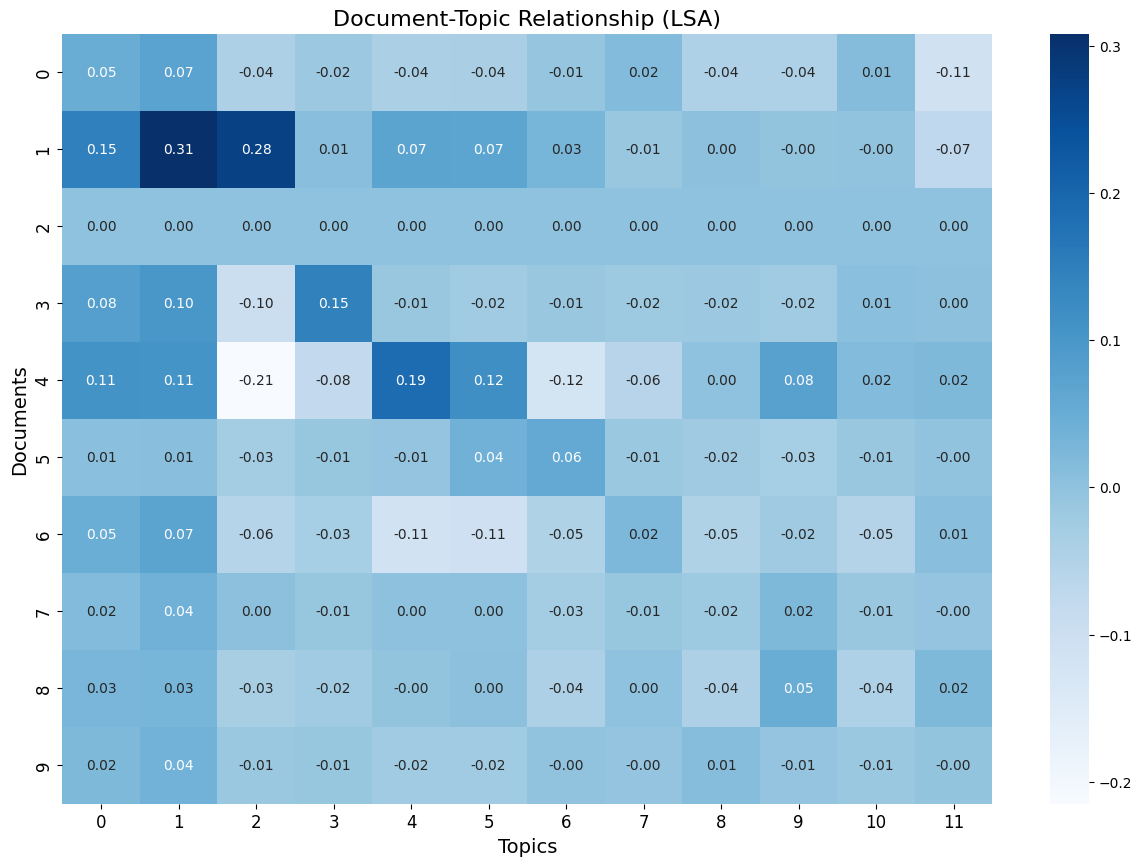

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size to make the heatmap larger
plt.figure(figsize=(15, 10))  # Adjust width and height as needed

# Create a heatmap for the first 10 documents and 12 topics
sns.heatmap(lsa_topics_sample[:10], annot=True, cmap='Blues', fmt=".2f")
plt.xlabel('Topics', fontsize=14)
plt.ylabel('Documents', fontsize=14)
plt.title('Document-Topic Relationship (LSA)', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [ ]:

# Display top words for each model

# Function to display top words
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
# Now you can access the feature names


print("\nLSA Topics (Sample Data):")
print_top_words(lsa_model_sample, vectorizer.get_feature_names_out())


LSA Topics (Sample Data):
Topic #1:
photo say city world time plan state game york american group illus president great day school set week work hold
Topic #2:
say plan illus state group president report today charge american war tax issue leader year official home york aid time
Topic #3:
say photo figure cost bush result past governor sec proposed german talk offered johnson sen suit describes economy press condition
Topic #4:
illus idea west force general people early say design police described teacher country face noted use met photo air left
Topic #5:
game win star home score say victory beat defeat set miss final lead team today play league victor mr opening
Topic #6:
york say illus american win bride world man make philadelphia married old girl william hard paul victor beat miss friend
Topic #7:
home city bride mr church miss married work today group open say jersey case girl ceremony graduate away wed win
Topic #8:
win state today score american defeat set miss beat title mill

In [ ]:
# Coherence for LSA
lsa_topics_words = [[vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]] for topic in lsa_model_sample.components_]
coherence_lsa_model = CoherenceModel(topics=lsa_topics_words, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lsa = coherence_lsa_model.get_coherence()
print(f"LSA Coherence Score: {coherence_lsa}")

LSA Coherence Score: 0.3602237687804582


#LDA

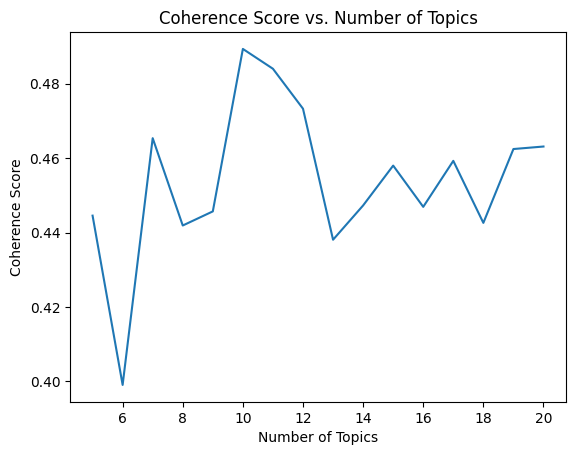

Optimal number of topics: 10


In [ ]:
import matplotlib.pyplot as plt

# Range of topic numbers to test
topic_numbers = list(range(5, 21))  # Testing from 5 to 20 topics
coherence_scores = []

# Run LDA for each number of topics and calculate coherence score
for num_topics in topic_numbers:
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=42, alpha='auto', eta='auto')

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Plot the coherence scores
plt.plot(topic_numbers, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()

# Get the number of topics with the highest coherence score
optimal_num_topics = topic_numbers[coherence_scores.index(max(coherence_scores))]
print(f"Optimal number of topics: {optimal_num_topics}")


In [ ]:
# Print the topics and keywords
for idx, topic in lda_model.print_topics(num_topics=10, num_words=20):
    print(f"Topic #{idx + 1}: {topic}")

Topic #10: 0.016*"economic" + 0.015*"room" + 0.012*"book" + 0.010*"say" + 0.010*"await" + 0.010*"chief" + 0.010*"total" + 0.010*"found" + 0.009*"level" + 0.009*"agent" + 0.009*"less" + 0.008*"nyc" + 0.008*"describes" + 0.007*"realty" + 0.007*"map" + 0.007*"estimate" + 0.007*"output" + 0.006*"sign" + 0.006*"war" + 0.006*"proposal"
Topic #4: 0.016*"bill" + 0.010*"patient" + 0.010*"child" + 0.010*"wall" + 0.010*"control" + 0.009*"california" + 0.008*"discussed" + 0.008*"office" + 0.008*"victim" + 0.008*"soldier" + 0.007*"indicates" + 0.007*"hold" + 0.007*"send" + 0.007*"check" + 0.007*"wait" + 0.007*"wednesday" + 0.007*"advance" + 0.006*"home" + 0.006*"type" + 0.006*"fishing"
Topic #6: 0.055*"ticket" + 0.015*"head" + 0.013*"south" + 0.013*"davis" + 0.012*"egypt" + 0.010*"painting" + 0.010*"denied" + 0.010*"finish" + 0.009*"union" + 0.009*"photo" + 0.009*"roosevelt" + 0.008*"feature" + 0.007*"paris" + 0.007*"remove" + 0.007*"hughes" + 0.007*"bergen" + 0.007*"refuse" + 0.006*"estate" + 0.00

In [ ]:
# Step 5: Evaluate Topic Coherence (using CoherenceModel from gensim)

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score: {coherence_lda}')

Coherence Score: 0.46312631123648795


In [ ]:
# Install pyLDAvis
%pip install pyLDAvis

# Import necessary libraries
import pyLDAvis
import pyLDAvis.gensim_models

# Prepare the pyLDAvis visualization
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

# Show the visualization
pyLDAvis.display(vis)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.0 MB/s eta 0:00:00
